In [ ]:
#!pip install torch torchvision tqdm


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vgg19
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
train_dir = "/kaggle/input/srgan-dataset/mirflickr"
hr_size = 128
lr_size = 32
max_images = 3000

In [4]:
os.makedirs("/kaggle/working/hr_images", exist_ok=True)
os.makedirs("/kaggle/working/lr_images", exist_ok=True)

In [5]:
image_files = [img for img in os.listdir(train_dir) if img.endswith(".jpg")]
for img in tqdm(image_files[:max_images]):
    img_array = cv2.imread(os.path.join(train_dir, img))
    img_array = cv2.resize(img_array, (hr_size, hr_size))
    lr_img_array = cv2.resize(img_array, (lr_size, lr_size))
    cv2.imwrite(os.path.join("/kaggle/working/hr_images", img), img_array)
    cv2.imwrite(os.path.join("/kaggle/working/lr_images", img), lr_img_array)

100%|██████████| 3000/3000 [00:24<00:00, 120.44it/s]


In [6]:
class SRDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, transform=None, max_images=8000):
        self.hr_dir = hr_dir    # high res dir
        self.lr_dir = lr_dir    # low res dir
        self.hr_images = os.listdir(hr_dir)[:max_images]
        self.lr_images = os.listdir(lr_dir)[:max_images]
        self.transform = transform

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr_img_path = os.path.join(self.hr_dir, self.hr_images[idx])
        lr_img_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_image = cv2.imread(hr_img_path)
        lr_image = cv2.imread(lr_img_path)

        hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
        lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)

        if self.transform:
            hr_image = self.transform(hr_image)
            lr_image = self.transform(lr_image)

        return lr_image, hr_image

In [7]:
hr_dir = "/kaggle/working/hr_images"
lr_dir = "/kaggle/working/lr_images"

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [9]:
dataset = SRDataset(hr_dir, lr_dir, transform=transform, max_images=max_images)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

## **Building the SRGAN Model**

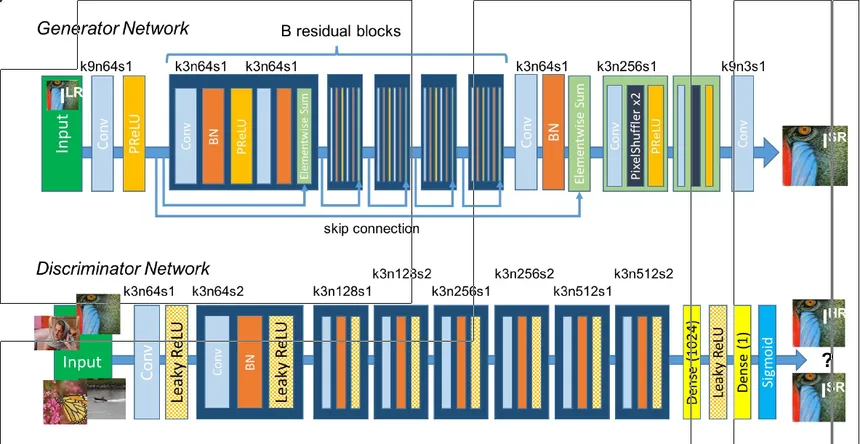

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features)
        )
    
    def forward(self, x):
        return x + self.block(x)

## **Generator**

`-` *** indicates seperating tuple or list into seperate individual items**

In [11]:
class Generator(nn.Module):
    def __init__(self, num_res_blocks=16):
        super(Generator, self).__init__()
        self.start = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )
        
        res_blocks = [ResidualBlock(64) for _ in range(num_res_blocks)]
        self.res_blocks = nn.Sequential(*res_blocks)
        
        self.mid = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        
        upsampling = []
        for _ in range(2):
            upsampling += [
                nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU()
            ]
            
        self.upsampling = nn.Sequential(*upsampling)
        
        self.final = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)
        
    def forward(self, x):
        out = self.start(x)
        residual = out
        out = self.res_blocks(out)
        out = self.mid(out)
        out = out + residual
        out = self.upsampling(out)
        out = self.final(out)
        return out

## **Discriminator**

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def disc_block(in_filters, out_filters, stride):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=stride, padding=1)]
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *disc_block(3, 64, 1),
            *disc_block(64, 64, 2),
            *disc_block(64, 128, 1),
            *disc_block(128, 128, 2),
            *disc_block(128, 256, 1),
            *disc_block(256, 256, 2),
            *disc_block(256, 512, 1),
            *disc_block(512, 512, 2),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1)
        )   
    
    def forward(self, img):
        out = self.model(img)
        return torch.sigmoid(out.view(out.size(0), -1))

## **VGG Feature Extractor**

In [13]:
from torchvision.models import vgg19

class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=35):
        super(VGGFeatureExtractor, self).__init__()
        vgg = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children())[:feature_layer])
        
    def forward(self, img):
        return self.feature_extractor(img)

## **Training Start**

In [14]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
vgg = VGGFeatureExtractor().to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 155MB/s]  


In [15]:
criterion_GAN = nn.BCELoss().to(device)
criterion_content = nn.MSELoss().to(device)

In [16]:
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)

In [29]:
losses_G = []
losses_D = []

num_epochs = 5
for epoch in range(num_epochs):
    for i, (lr_imgs, hr_imgs) in enumerate(dataloader):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        valid = torch.ones_like(discriminator(hr_imgs), requires_grad=False, device=device)
        fake = torch.zeros_like(discriminator(hr_imgs), requires_grad=False, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        
        gen_imgs = generator(lr_imgs)
        pred_fake = discriminator(gen_imgs)
        
        # Adversarial loss
        loss_GAN = criterion_GAN(pred_fake, valid)
        
        # Content loss
        gen_features = vgg(gen_imgs)
        real_features = vgg(hr_imgs).detach()
        loss_content = criterion_content(gen_features, real_features)
        
        # Total loss
        loss_G = loss_GAN + 1e-3 * loss_content
        
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        
        pred_real = discriminator(hr_imgs)
        pred_fake = discriminator(gen_imgs.detach())
        
        loss_real = criterion_GAN(pred_real, valid)
        loss_fake = criterion_GAN(pred_fake, fake)
        
        loss_D = (loss_real + loss_fake) / 2
        
        loss_D.backward()
        optimizer_D.step()

        # Store losses
        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i+1}/{len(dataloader)}] "
              f"Loss D: {loss_D.item():.4f}, loss G: {loss_G.item():.4f}")

    # Save models
    if (epoch + 1) % 1 == 0:
        torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")

Epoch [1/5] Batch [1/3000] Loss D: 0.0539, loss G: 2.5064
Epoch [1/5] Batch [2/3000] Loss D: 0.1638, loss G: 2.7315
Epoch [1/5] Batch [3/3000] Loss D: 0.0256, loss G: 3.7842
Epoch [1/5] Batch [4/3000] Loss D: 0.0191, loss G: 3.6494
Epoch [1/5] Batch [5/3000] Loss D: 0.6226, loss G: 3.0091
Epoch [1/5] Batch [6/3000] Loss D: 1.1301, loss G: 2.3427
Epoch [1/5] Batch [7/3000] Loss D: 0.5987, loss G: 3.0465
Epoch [1/5] Batch [8/3000] Loss D: 0.3156, loss G: 0.9998
Epoch [1/5] Batch [9/3000] Loss D: 1.1374, loss G: 1.1053
Epoch [1/5] Batch [10/3000] Loss D: 0.1234, loss G: 1.5995
Epoch [1/5] Batch [11/3000] Loss D: 0.1840, loss G: 1.3088
Epoch [1/5] Batch [12/3000] Loss D: 0.3003, loss G: 0.8640
Epoch [1/5] Batch [13/3000] Loss D: 0.5650, loss G: 0.4503
Epoch [1/5] Batch [14/3000] Loss D: 0.1828, loss G: 1.8966
Epoch [1/5] Batch [15/3000] Loss D: 0.1412, loss G: 2.3227
Epoch [1/5] Batch [16/3000] Loss D: 0.0800, loss G: 2.0021
Epoch [1/5] Batch [17/3000] Loss D: 0.1973, loss G: 2.2709
Epoch 

In [30]:
generator.load_state_dict(torch.load('generator_epoch_5.pth'))
generator.eval()

Generator(
  (start): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, mo

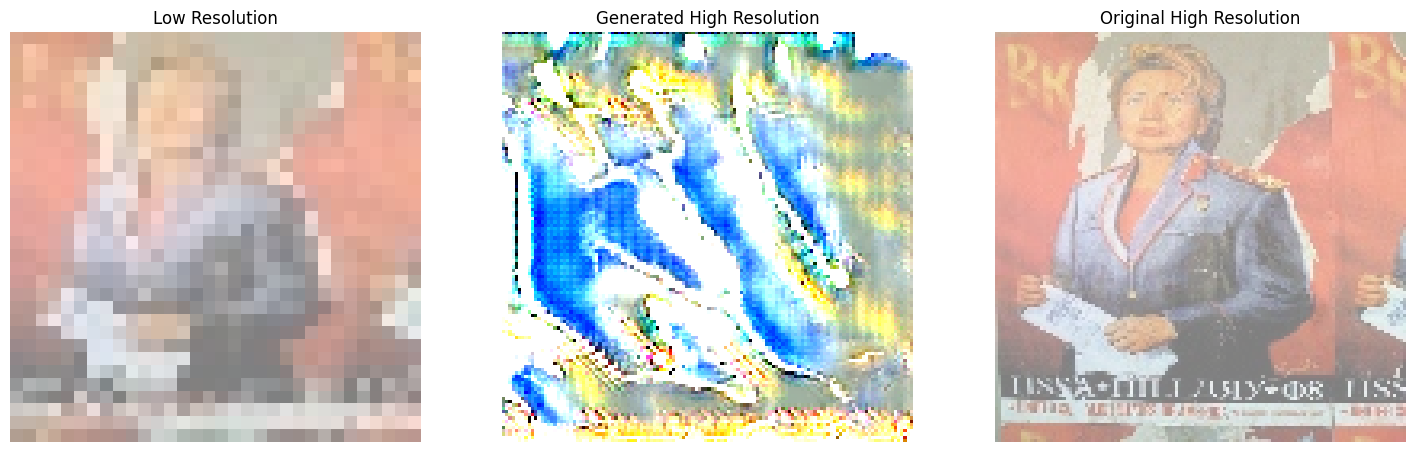

In [31]:

def plot_images(lr_img, gen_img, hr_img):
    lr_img = lr_img.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    gen_img = gen_img.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    hr_img = hr_img.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Low Resolution')
    plt.imshow((lr_img * 0.5 + 0.5))
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Generated High Resolution')
    plt.imshow((gen_img * 0.5 + 0.5))
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Original High Resolution')
    plt.imshow((hr_img * 0.5 + 0.5))
    plt.axis('off')
    
    plt.show()

for lr_img, hr_img in dataloader:
    lr_img, hr_img = lr_img.to(device), hr_img.to(device)
    with torch.no_grad():
        gen_img = generator(lr_img)
    plot_images(lr_img, gen_img, hr_img)
    break

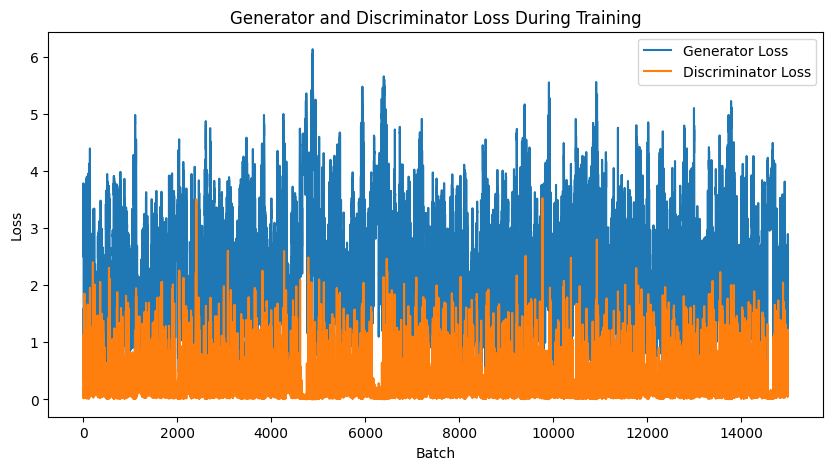

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss During Training')
plt.legend()
plt.show()